In [5]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd

src_path = Path(
    "/Users/pszyc/Library/CloudStorage/GoogleDrive-przemek.7678@gmail.com/My Drive/Studia/Ogniska/"
)

data_files = list(src_path.rglob("00*"))

data_files = [path for path in data_files if (path / "foci_mask.npy").exists()]
print(len(data_files))

679


In [49]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.ndimage import label

rows_ch1 = []
rows_ch2 = []
rows_overlap = []

def append_components(binary_mask, image_info, out_rows):
    cc_mask, n_cc = label(binary_mask, structure=np.ones((3, 3, 3), dtype=np.uint8))
    if n_cc == 0:
        return
    sizes = np.bincount(cc_mask.ravel())[1:]  # skip background
    for comp_label, comp_size in enumerate(sizes, start=1):
        out_rows.append({
            "image_info": image_info,
            "foci_label": int(comp_label),
            "foci_size": int(comp_size),
        })

for data_selected in tqdm(data_files):
    image_info = "/".join(str(data_selected).split("/")[-3:])
    foci_mask_path = data_selected / "foci_mask.npy"

    # expected shape: (2, Z, Y, X)
    mask = np.load(foci_mask_path)
    mask = mask[:, 11:30, :, :]

    ch1_mask = mask[0] > 0
    ch2_mask = mask[1] > 0
    overlap_mask = ch1_mask & ch2_mask

    append_components(ch1_mask, image_info, rows_ch1)
    append_components(ch2_mask, image_info, rows_ch2)
    append_components(overlap_mask, image_info, rows_overlap)

def rows_to_df(rows):
    if len(rows) == 0:
        return pd.DataFrame(columns=["image_info", "foci_label", "foci_size"])
    return (
        pd.DataFrame(rows)
        .sort_values(["image_info", "foci_label"])
        .reset_index(drop=True)
    )

ch1_df = rows_to_df(rows_ch1)
ch2_df = rows_to_df(rows_ch2)
overlap_df = rows_to_df(rows_overlap)

# keep backward compatibility with later cells

print(f"ch1_df: {len(ch1_df)} rows")
print(f"ch2_df: {len(ch2_df)} rows")
print(f"overlap_df: {len(overlap_df)} rows")

ch1_df.head()

100%|██████████| 679/679 [10:04<00:00,  1.12it/s]


ch1_df: 486234 rows
ch2_df: 648874 rows
overlap_df: 490468 rows


,image_info,foci_label,foci_size
0,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",1,165
1,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",2,18
2,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",3,79
3,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",4,123
4,"NHDF_30min PI/IR 0,5Gy_30min PI/0001",5,56


In [50]:
ch1_df.to_csv("foci_ch1.csv", index=False)
ch2_df.to_csv("foci_ch2.csv", index=False)
overlap_df.to_csv("foci_overlap.csv", index=False)

print("Saved: foci_ch1.csv, foci_ch2.csv, foci_overlap.csv")

Saved: foci_ch1.csv, foci_ch2.csv, foci_overlap.csv


In [61]:
ch1_df = pd.read_csv("foci_ch1.csv")
ch2_df = pd.read_csv("foci_ch2.csv")
overlap_df = pd.read_csv("foci_overlap.csv")

# keep backward compatibility with later cells
print(f"Loaded ch1_df: {len(ch1_df)} rows")
print(f"Loaded ch2_df: {len(ch2_df)} rows")
print(f"Loaded overlap_df: {len(overlap_df)} rows")

Loaded ch1_df: 486234 rows
Loaded ch2_df: 648874 rows
Loaded overlap_df: 490468 rows


In [62]:
z_scale, x_scale, y_scale = 50 / 48, 1040 / 505, 1392 / 681

def add_volume_features(df, size_col="foci_size"):
    df = df.copy()
    df["vol"] = df[size_col] * 0.065 * 0.065 * 0.3 * z_scale * x_scale * y_scale
    df["x"] = np.cbrt(df["vol"])
    return df

ch1_df = add_volume_features(ch1_df)
ch2_df = add_volume_features(ch2_df)
overlap_df = add_volume_features(overlap_df)

# keep backward compatibility with downstream cells
print("Processed: ch1_df, ch2_df, overlap_df")

Processed: ch1_df, ch2_df, overlap_df


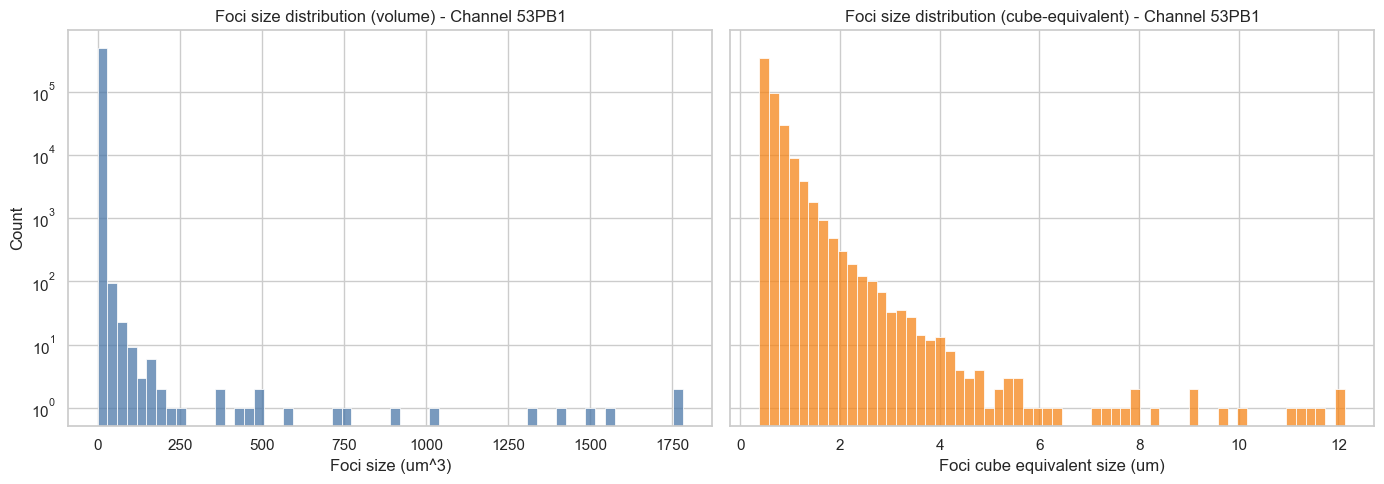

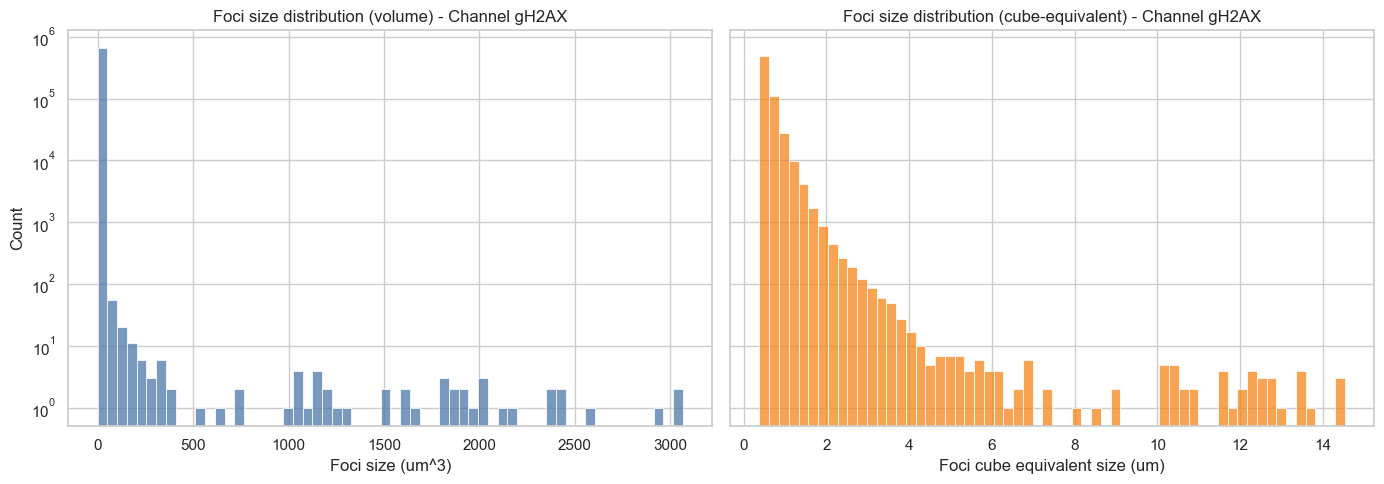

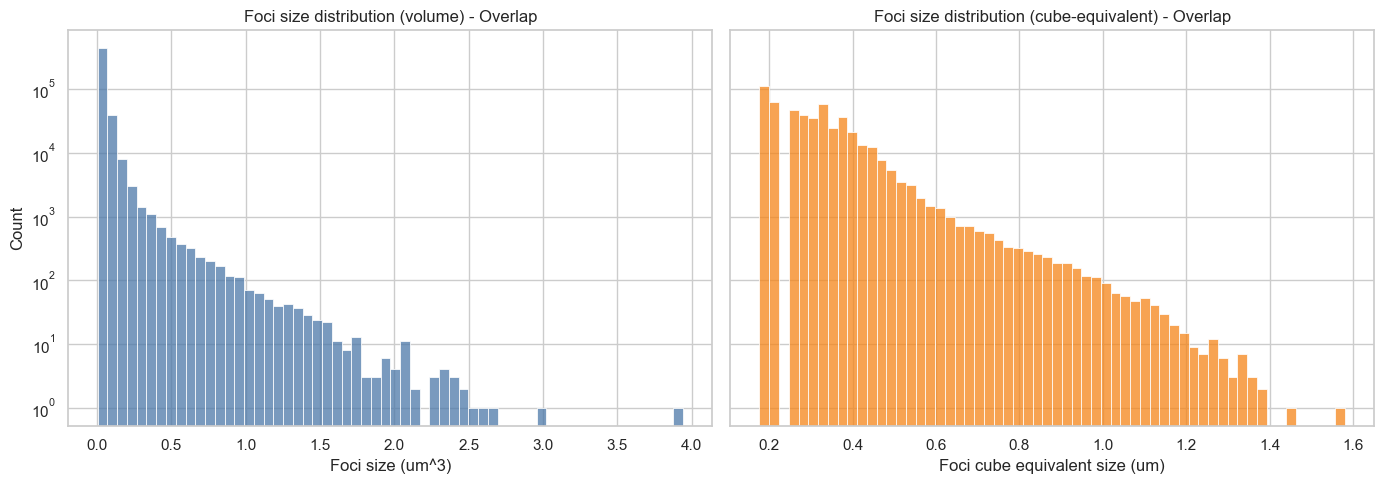

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_volume_vs_cube_root_distribution(df, title_suffix="", bins=60):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Left: foci volume (um^3)
    sns.histplot(
        data=df,
        x="vol",
        bins=bins,
        kde=False,
        ax=axes[0],
        color="#4C78A8"
    )
    axes[0].set_title(f"Foci size distribution (volume){title_suffix}")
    axes[0].set_xlabel("Foci size (um^3)")
    axes[0].set_ylabel("Count")
    axes[0].set_yscale("log")

    # Right: cube root of volume (um)
    sns.histplot(
        data=df,
        x="x",
        bins=bins,
        kde=False,
        ax=axes[1],
        color="#F58518"
    )
    axes[1].set_title(f"Foci size distribution (cube root of volume){title_suffix}")
    axes[1].set_xlabel("Foci cube root of volume (um)")
    axes[1].set_ylabel("Count")
    axes[1].set_yscale("log")

    plt.tight_layout()
    plt.show()

plot_volume_vs_cube_root_distribution(ch1_df, " - Channel 53PB1")
plot_volume_vs_cube_root_distribution(ch2_df, " - Channel gH2AX")
plot_volume_vs_cube_root_distribution(overlap_df, " - Overlap")